## 5. Decision Trees and Ensemble Learning

This project is about building a model that a bank can use to help in the decision of whether to make a loan or not. 

The bank wants to know if you can pay back the loan, so this can be done by measuring the risk of a person not paying back the loan, called the __probability of default__.

$ y_{i} \in \{0, 1\} $

$ g(x_{i}) \space \rightarrow \space $ probability of default


- The repository of this chapter can be accessed [here](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/06-trees)  
- Data file is the `CreditScoring.csv` available [here](https://github.com/gastonstat/CreditScoring)

### 5.1 Data cleaning and preparation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### 5.1.1 Downloading the data

In [2]:
data = 'https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv'

In [3]:
#!wget $data 

In [4]:
!head ../data/CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv('../data/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Let's lower case the column names:

In [6]:
df.columns = df.columns.str.lower()

#### 5.1.2 Re-encoding the categorical values

Our dataset has all its variables in numbers, so we have to re-encode that. The encoding used by the author can be seen [here](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R) in line 131.

As we can see, we have to re-encode these variables:

- status
- home
- marital
- records
- job

In [7]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


As we can see in the author's notebook, there were some encoding for missing values (line 59) that we have to consider. There are three columns in this situation:

- income
- assets
- debt

In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Finally, we have an `'unk'` value in `status`, we can get rid of it:

In [11]:
df['status'].value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [12]:
df = df[df['status'] != 'unk'].reset_index(drop=True)

In [13]:
df['status'].value_counts()

ok         3200
default    1254
Name: status, dtype: int64

#### 5.1.3 Spliting the data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train['status'] == 'default').astype('int').values
y_val = (df_val['status'] == 'default').astype('int').values
y_test = (df_test['status'] == 'default').astype('int').values

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


### 5.2 Decision trees

#### 5.2.1 How a decision tree looks like

Decision trees are a series of `if` statementes. It can be represented as follows:

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

Converting the data frame into a dictionary and training a `DictVectorizer`, taking into account that we have some `NaN `values when we re-encoded the data for `999999999` values:

In [21]:
train_dict = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

#### 5.2.2 Training a decision tree

In [23]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Testing our tree model:

In [24]:
val_dict = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dict)

In [25]:
y_pred = tree.predict_proba(X_val)[:, 1]

Measuring the model performance:

In [26]:
roc_auc_score(y_pred, y_val)


0.6732125238439782

And if we compare this value against the performance on the training data:

In [27]:
y_pred_train = tree.predict_proba(X_train)[:, 1]
roc_auc_score(y_pred_train, y_train)

1.0

This results reflects __overfiting__!

#### 5.2.3 Controlling the size of a tree

Decision Tree Overfitin happens because the model can learn a specific rule to every customer in the training dataset. One way to avoid this is by limiting the model's depth.

Let's see what happen if we use a limitation of 3:

In [28]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [29]:
y_pred = tree.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'train score: {round(auc, 4)}')

y_pred = tree.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'validation score: {round(auc, 4)}')

train score: 0.7761
validation score: 0.7389


We can visualize the tree and its features by doing this:

In [30]:
from sklearn.tree import export_text

In [31]:
print(export_text(tree, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



### 5.3 Decision tree learning algorithm

To do this, we'll use a simplier dataset.

In [32]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Remember that the model uses a _threshold_ to decide on each node. If we train a model with the above data we'll have just one decision (`assets`)... What's the best _threshold_ here?

In [33]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


What we can see is that we have a list of possible thresholds to split the data in the node `assets`. Being T equals to the potential thresholds:

In [40]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [41]:
for T in Ts:
    df_right = df_example[df_example['assets'] > T]
    df_left = df_example[df_example['assets'] <= T]

    print(T)
    display(df_right)
    display(df_left)


0


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
2,0,default


2000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
1,2000,default
2,0,default


3000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
7,3000,default


4000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


5000


,assets,status
0,8000,default
6,9000,ok


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


8000


,assets,status
6,9000,ok


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


#### 5.3.1 Finding the best split for a column

Based on the above results, how can we find the best T? We'll have to use a measurement for that: the __missclassification rate_ (impurity) which is how many errors did we have in both sides of the node.

At the end we can have a wighted average between both to have a final mesurement for our model with a particualr value of __T__.

As an example, we'll caluculate the __impurity__ for `T = 4000`

In [44]:
T = 4000
df_right = df_example[df_example['assets'] > T]
df_left = df_example[df_example['assets'] <= T]

print(T)
display(df_right)
print(df_right['status'].value_counts(normalize=True))
display(df_left)
print(df_left['status'].value_counts(normalize=True))

4000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


This means that, the impurity on `'default'` is 25% and the same value for the impurity on `'ok'`, so a simple average here is 25%.

If we repeat this proces with every __T__, we're going to conclude that the lowest __impurity__ average would be for `T = 3000` with an `impurity = 10%`

#### 5.3.2 Stopping criteria

These are some of the stopping criteria we can use:

- A group is already pure (just one status present)
- Tree reach depth limit
- Group is too small to split

__Decision Tree Algorithm__:

1. FIND THE BEST SPLIT
2. STOP IF MAX_DEPTH IS REACHED
3. IF LEFT IS SUFFICINETLY LARGE AND NOT PURE:
        REPEAT FOR LEFT
4. IF RIGHT IS SUFFICINETLY LARGE AND NOT PURE:
        REPEAT FOR RIGHT

More on this [here](https://scikit-learn.org/stable/modules/tree.html).

### 5.4 Decision tree parameters tuning

#### 5.4.1 Selecting `max_depth`

In [45]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)

    y_pred = tree.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.760
  10 -> 0.686
  15 -> 0.658
  20 -> 0.657
None -> 0.652


As we see, the best depth parameter is 5, but we can say that any value between 4 and 6 levels. In that case, we could select max_depth = 4 because this model would be simpler than the others.

Now let's analyze those values with `min_sample_lear`.

#### 5.4.2 Selecting `min_sample_leaf`

In [52]:
scores = []

for depth in [4, 5, 6]:
    for leaf in [1, 2, 5, 15, 20, 100, 200, 500]:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
        tree.fit(X_train, y_train)

        y_pred = tree.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, leaf, auc))

In [61]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_sample_leaf', 'auc'])
df_scores.sort_values('auc', ascending=False).head()

,max_depth,min_sample_leaf,auc
19,6,15,0.785319
21,6,100,0.776434
12,5,20,0.773537
20,6,20,0.773337
11,5,15,0.772723


Another way of veiwing this dataset is this:

In [63]:
df_scores_pivot = df_scores.pivot(index='min_sample_leaf', columns=['max_depth'])
df_scores_pivot.round(3)

auc              
max_depth            4      5      6
min_sample_leaf                     
1                0.761  0.767  0.747
2                0.761  0.766  0.750
5                0.761  0.768  0.762
15               0.764  0.773  0.785
20               0.761  0.774  0.773
100              0.756  0.763  0.776
200              0.747  0.759  0.768
500              0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_sample_leaf'>

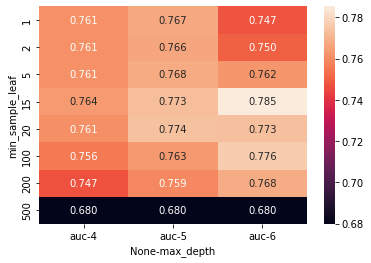

In [66]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

This tell us that maybe there could be another combination of the two parameters that maximizes the `auc` value.

For now, let's try with our final model:

In [67]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

### 5.5 Ensembles and random forest

#### 5.5.1 Board of experts

#### 5.5.2 Ensemblimg models

#### 5.5.3 Random forest - ensembling decision tree

#### 5.5.4 Tuning random forest